# Assignment #4 - Neural Networks

### <font color="red"> DUE: Nov 16 (Thursday) 11:00 pm </font>  

<font color="blue"> Josiah Laivins </font>

# I. Overview
## Regression
For regression, I choose the housing dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Their dataset consists of a total of 1461 samples, and about 80 features to use.
My goal is to use regression to predict housing prices. As a note, there are another 1460 samples, however they removed the SalesPrice column since that is the part of the competition.



## Classification
There is an interesting dataset found at: https://www.kaggle.com/zalando-research/fashionmnist

Training a custom neural net for classifying clothing images seemed fun to test on. It consists of a total of 10 classes with 70,000 samples. They pre-separate the set into training and test sets, however I will combine them to do my own train-test splitting.

I will be using a logistic neural net that can have an optional number of hidden layers to find advanced non-linear features.

# II. Data - Regression

In [ ]:
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from LeeNeuralNet import NeuralNet
from util import *
%matplotlib inline
warnings.filterwarnings("ignore", category=DataConversionWarning)

""" Load data """
data_raw = pd.read_csv('./data/housing_prices/train.csv', nrows=None)
# Drop rows where (specific) columns are nan, and the Id column, and set the rest of nan to 0
data = data_raw.dropna(subset=list(set(data_raw.columns) - {'Alley', 'PoolQC', 'Fence', 'MiscFeature'}), axis=0)
data = data.drop(axis=1, columns='Id')
data = data.fillna('0')

""" Encode Dataframe """
encoder_d = defaultdict(LabelEncoder)

Y = data['SalePrice']
X = data.drop(axis=1, columns='SalePrice')  # type: pd.DataFrame
X = X.apply(lambda x: encoder_d[x.name].fit_transform(x))
X_value = np.array(X.values)
Y_value = np.array(Y.values).reshape(-1, 1)

""" Normalize Data """
standard_x_d = MinMaxScaler()
X_norm = standard_x_d.fit_transform(X.values)
standard_y = MinMaxScaler()
Y_norm = standard_y.fit_transform(Y.values.reshape(-1, 1))

print(f'  Data loaded. Training X shape: {X_value.shape} Y shape: {Y_value.shape}')

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


  Data loaded. Training X shape: (583, 79) Y shape: (583, 1)


In [ ]:
""" Set up K-Fold """
k_folds = 2

# Logs for K and the params to test
train_params = [{'struct':[X_value.shape[1], 15, 1]}]
rmse_test_per_iter = []
rmse_train_per_iter = []
cost_log_per_iter = []
best_param_per_iter = []

""" Add unique ids for each param to be identified by """
for i in range(len(train_params)):
    train_params[i]['id'] = i

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.20)
from_k = 0
# For each K
for k in tqdm(range(k_folds), bar_format='r_bar'):
    X_train_per_k = X_train[from_k:from_k+int(X_train.shape[0] / k_folds)]
    y_train_per_k = y_train[from_k:from_k+int(y_train.shape[0] / k_folds)]

    from_k += from_k+int(X_train.shape[0] / k_folds)

    # Test each param
    for param in train_params:
        """ Build Neural Net """
        nn = NeuralNet(param['struct'])
        """ Train Neural Network """
        nn.train(X_train_per_k, y_train_per_k, ftracep=True, wtracep=True)

        # Set test rmse local or res
        rmse_train_per_iter.append(nn.ftrace)
        best_param_per_iter.append(param)

""" Show the parameters and their performance """
plot_k_folds(k_folds, best_param_per_iter, extra_params=(rmse_train_per_iter,),
             labels=['K', 'RMSE for Train', 'Params'])
plt.show()

""" Keep the top 5 best """
import copy

top = 2

best_indices = np.array([_[-1] for _ in rmse_train_per_iter]).argsort()[:top]
copy_best_param_per_iter = copy.deepcopy([best_param_per_iter[i] for i in best_indices])
_, counts = np.unique([p['id'] for p in copy_best_param_per_iter], return_counts=True)

best_iter = best_indices[counts.argmax()]

# Copy the params because I dont want to accidentally reset them...
copy_rmse_train = rmse_train_per_iter[best_iter]

""" Plot the test and train RMSE """
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
plt.plot(copy_rmse_train)
plt.title(f'Best Param is: {get_formatted_params(best_param_per_iter[best_iter], include_values=True)} \n\n with final'+
          f' test RMSE of {copy_rmse_train[-1]}')
plt.xlabel('Epochs')
plt.ylabel('RMSE of best for Test and training')
plt.show()

""" Show the full model performance on test data """
prediction_y = nn.use(X_test)
plt.figure(figsize=(15,5))
plt.plot(range(len(X_test)), y_test, 'o-', range(len(X_test)), prediction_y, 'o-')
plt.xlim(0, int(len(X_test)/2))
plt.legend(('Testing', 'Model'), loc='upper left')
plt.xlabel('$x$')
plt.ylabel('Actual and Predicted $f(x)$')


/Users/jlaivins/PycharmProjects/MachineLearningBackUp/src/ITCS6156MachineLearningCourse/josiah_laivins_assignment_4/Standardizer.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num((X - self._mu) / self._sigma)


# II. Data - Classification

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


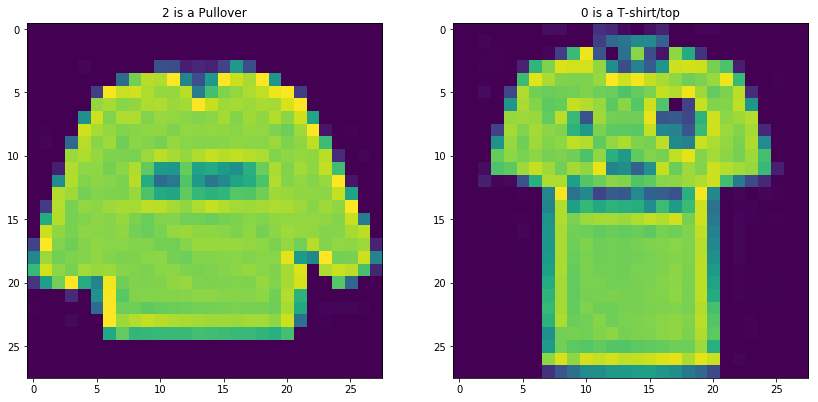

/Users/jlaivins/PycharmProjects/MachineLearningBackUp/src/ITCS6156MachineLearningCourse/josiah_laivins_assignment_4/Standardizer.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num((X - self._mu) / self._sigma)


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook as tqdm
from Layer import Layer
from NeuralNetwork import NeuralNetLogReg

%matplotlib inline

""" Dictionary of the classification values and their string equivalent """
classification_name = {0: 'T-shirt/top',
                       1: 'Trouser',
                       2: 'Pullover',
                       3: 'Dress',
                       4: 'Coat',
                       5: 'Sandal',
                       6: 'Shirt',
                       7: 'Sneaker',
                       8: 'Bag',
                       9: 'Ankle boot'}

""" The train and test sets are already split """
train = pd.read_csv('./data/fashionmnist/fashion-mnist_train.csv', nrows=300)
test = pd.read_csv('./data/fashionmnist/fashion-mnist_test.csv', nrows=300)

""" These are images that are 28x28, the column 0 is the label """
pic_train = np.array(train.iloc[0, 1:]).reshape((28, 28))
pic_test = np.array(test.iloc[0, 1:]).reshape((28, 28))

""" Example of the data that will be used """
fig = plt.figure(figsize=(14, 14))
fig.add_subplot(1, 2, 1)
plt.title(f'{train.loc[0][0]} is a {classification_name[train.loc[0][0]]}')
plt.imshow(pic_train)
fig.add_subplot(1, 2, 2)
plt.title(f'{test.loc[0][0]} is a {classification_name[test.loc[0][0]]}')
plt.imshow(pic_test)
plt.show()

""" Convert Pandas Frames into X and Y """
combined_X = pd.concat((train, test)).reset_index(drop=True)

X = np.array(combined_X.iloc[:, 1:])
Y = np.array(combined_X.iloc[:, 0]).reshape(-1, 1)

""" Normalize and Standardize X and Y """
from Standardizer import Standardizer

standardizer_x = Standardizer(X)
stand_X = standardizer_x.standardize(X)
encoder = OneHotEncoder()
encoder.fit(Y)
stand_Y = encoder.transform(Y).toarray()

# III. Methods - Classification

The nonlinear regression model takes in 784 pixel sample and compares it against a onehot target. You can add any number of layers for discovering high level features. This is a regression neuralnetwork wince the neuron activations are continuous, and linear classification can be performed based on the activations from the sigmoid functions. This is nonlinear since we combine linear neurons into a layered network.

The goal is to toggle the weights to reduce the total cost. This is done using an adam optimizer. The metric that is used is RMSE, and the network tracks RMSE for both training and testing sets.

- [X] Summarize the nonlinear regression model. 
- [X] Use the NeuralNet class for regression to apply to your data. 
- [X] Explain your codes. 
- [x] Explain and use 5-fold cross validation to find a good neural network parameters including the structure and report the test accuracy. 

In [24]:

""" Set up K-Fold """
k_folds = 2

# Logs for K and the params to test
train_params = [{'n_hidden_layers': 1, 'layer_sizes': [32], 'epochs': 50, 'input_bias':False, 'hidden_bias': [False],
                 'activation_type': ['sigmoid']},
                {'n_hidden_layers': 1, 'layer_sizes': [32], 'epochs': 50, 'input_bias':True, 'hidden_bias': [True],
                 'activation_type': ['sigmoid']},
                # {'n_hidden_layers': 1, 'layer_sizes': [16], 'epochs': 500, 'input_bias':True, 'hidden_bias': [True],
                #  'activation_type': ['sigmoid']},
                ]
rmse_test_per_iter = []
rmse_train_per_iter = []
cost_log_per_iter = []
best_param_per_iter = []

""" Add unique ids for each param to be identified by """
for i in range(len(train_params)):
    train_params[i]['id'] = i

X_train, X_test, y_train, y_test = train_test_split(stand_X, stand_Y, test_size=0.20)
from_k = 0
# For each K
for k in tqdm(range(k_folds), bar_format='r_bar'):
    X_train_per_k = X_train[from_k:from_k+int(X_train.shape[0] / k_folds)]
    y_train_per_k = y_train[from_k:from_k+int(y_train.shape[0] / k_folds)]

    from_k += from_k+int(X_train.shape[0] / k_folds)
    # Test each param
    for param in train_params:
        """ Build Neural Net """
        nn = NeuralNetLogReg(X_train_per_k, y_train_per_k, X_test, y_test)
        nn.add_layer(Layer(X_train_per_k[0].shape, is_input=True, name='Input Layer', use_bias=True))
        # Based on the params, build the network
        for i in range(param['n_hidden_layers']):
            nn.add_layer(Layer(param['layer_sizes'][i], name=f'Hidden Layer {i}',
                               use_bias=param['hidden_bias'][i],
                               activation=param['activation_type'][i]))
        nn.add_layer(Layer(y_train_per_k.shape[1], is_output=True, name='Output Layer'))

        """ Train Neural Network """
        nn.train(X_train_per_k, y_train_per_k, epochs=param['epochs'])

        # Set test rmse local or res
        rmse_test_per_iter.append(nn.log_rmse_test)
        rmse_train_per_iter.append(nn.log_rmse_train)
        cost_log_per_iter.append(nn.cost_log)
        best_param_per_iter.append(param)

DEBUG:root:I am an Output Layer, so there is no w output. Setting this to None will prevent accidentalusage.
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
  0%|          | 0/50 [00:00<?, ?it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 42%|████▏     | 21/50 [00:00<00:00, 49.21it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an inpu

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 80%|████████  | 40/50 [00:00<00:00, 53.97it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an inpu

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 60%|██████    | 30/50 [00:01<00:00, 29.74it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an inpu

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
100%|██████████| 50/50 [00:01<00:00, 34.01it/s]
DEBUG:root:I am an Output Layer, so there is no w output. Setting this to None will prevent accidentalusage.
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
  0%|          | 0/50 [00:00<?, ?it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation functi

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 38%|███▊      | 19/50 [00:00<00:00, 59.54it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an inpu

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 18%|█▊        | 9/50 [00:00<00:00, 42.94it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 58%|█████▊    | 29/50 [00:00<00:00, 33.11it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an inpu

 94%|█████████▍| 47/50 [00:01<00:00, 38.24it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an inpu

# IV - Results

- Presents the results of comparison of the tested models.
- Visualize the results 
- Discuss about the choice of parameters for each model 
- What do you think about the results? 

DEBUG:root:height for k fold figure is 8


Text(0,0.5,'Cost of best')

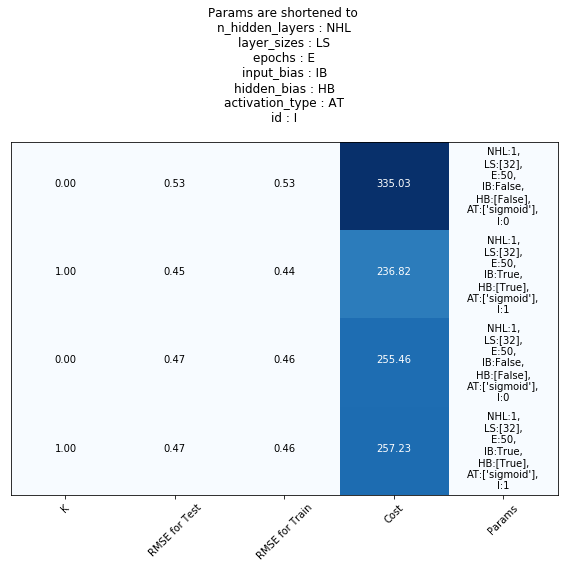

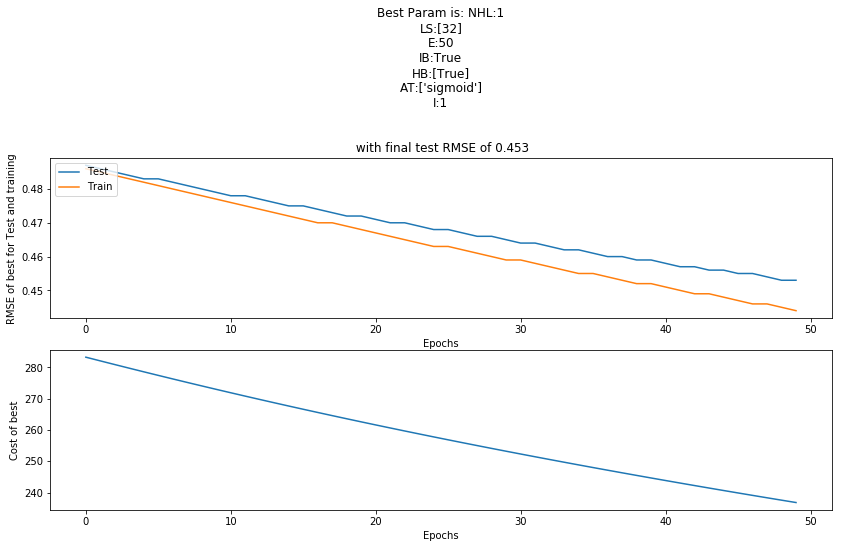

In [25]:
import copy
from util import *

""" Show the parameters and their performance """
plot_k_folds(k_folds, best_param_per_iter, extra_params=(rmse_test_per_iter, rmse_train_per_iter, cost_log_per_iter))

""" Keep the top 5 best """
top = 5

best_indices = np.array([_[-1] for _ in rmse_test_per_iter]).argsort()[:top]
copy_best_param_per_iter = copy.deepcopy([best_param_per_iter[i] for i in best_indices])
_, counts = np.unique([p['id'] for p in copy_best_param_per_iter], return_counts=True)

best_iter = best_indices[counts.argmax()]

# Copy the params because I dont want to accidently reset them...
copy_rmse_test = rmse_test_per_iter[best_iter]
copy_rmse_train = rmse_train_per_iter[best_iter]
copy_cost_log = cost_log_per_iter[best_iter]
copy_best_param = best_param_per_iter[best_iter]

""" Plot the test and train RMSE """
plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
plt.plot(copy_rmse_test)
plt.title(f'Best Param is: {get_formatted_params(best_param_per_iter[best_iter], include_values=True)} \n\n with final'+
          f' test RMSE of {rmse_test_per_iter[best_iter][-1]}')
plt.xlabel('Epochs')
plt.ylabel('RMSE of best for Test and training')
plt.plot(copy_rmse_train)
plt.legend(('Test','Train'),loc='upper left')

plt.subplot(3,1,2)
plt.plot(copy_cost_log)
plt.xlabel('Epochs')
plt.ylabel('Cost of best')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(stand_X, stand_Y, test_size=0.33)
nn = NeuralNetLogReg(X_train, y_train, X_test, y_test)
nn.add_layer(Layer(stand_X[0].shape, is_input=True, name='Input Layer', use_bias=copy_best_param['input_bias']))
# Based on the params, build the network
for i in range(copy_best_param['n_hidden_layers']):
    nn.add_layer(Layer(copy_best_param['layer_sizes'][i], name=f'Hidden Layer {i}',
                   use_bias=copy_best_param['hidden_bias'][i],
                   activation=copy_best_param['activation_type'][i]))
    nn.add_layer(Layer(y_train.shape[1], is_output=True, name='Output Layer'))

""" Train Neural Network """
nn.train(X_train, y_train, epochs=copy_best_param['epochs'])

DEBUG:root:I am an Output Layer, so there is no w output. Setting this to None will prevent accidentalusage.
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
  0%|          | 0/50 [00:00<?, ?it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 42%|████▏     | 21/50 [00:00<00:01, 25.25it/s]DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an inpu

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function
 82%|████████▏ | 41/50 [00:01<00:00, 26.92it/s]DEBUG:root:I am Input Layer and I am an inpu

DEBUG:root:I am Input Layer and I am an input layer. So I am not going to run an activation function


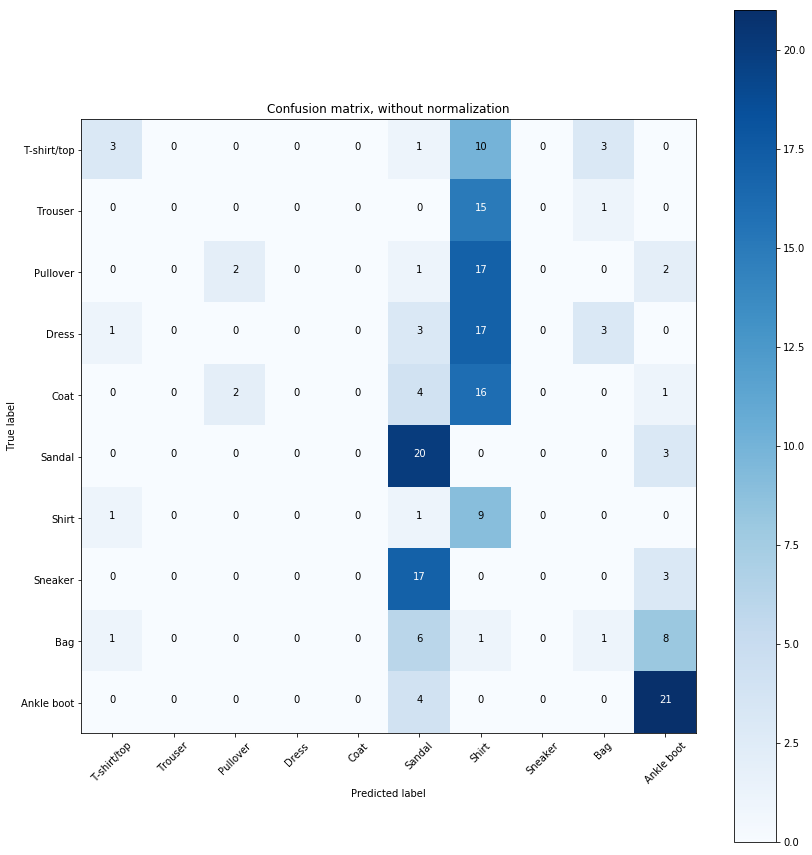

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scikit_learn-0.19.2-py3.6-macosx-10.9-x86_64.egg/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


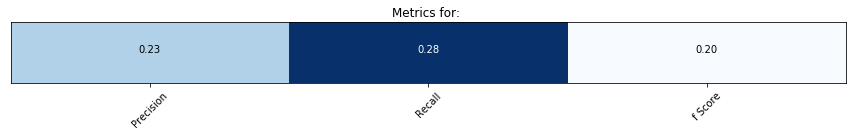

In [27]:
""" Use Neural Network """
y_labeled = np.argmax(copy.deepcopy(y_test), axis=1)
y_predict = nn.use(X_test)

""" Compute and plot confusion matrix """
cnf_matrix = confusion_matrix(y_labeled, y_predict)
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes=[classification_name[c] for c in classification_name],
                      title='Confusion matrix, without normalization')
plt.show()

""" Plot Metrics: Precision / Recall / F score """
from sklearn.metrics import precision_recall_fscore_support
plt.figure(figsize=(12, 2))
metrics = precision_recall_fscore_support(y_labeled, y_predict, average='weighted')
plot_precision_recall_f1(metrics, ['Precision', 'Recall', 'f Score'])
plt.show()

# Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

# Extra Credit

Extra credit is solved by the above code in the methods section:

- [x] Finish the following nonlinear logistic regression class and apply to your classification data. 
- [x] Use cross validation to discover the best model. 

# Deep Learning (2 Extra Credits)


For A5 extra credits, you build a deep network with more than 5 layers using TensorFlow. 
Main task for this work is converting your neural network codes with TensorFlow and searching for good structures that works well for your data. 
This includes following tasks.

- Pick at least 3 different networks for experiments.
- Summarize the choice of your networks. 
- Explain your TensorFlow codes. 
- Explain how you apply your model to your data. 
- Results
  - Presents the results of applications of your deep networks.
  - Visualize the results 
  - Discuss about the choice of network structures and performance of it as you change the structures.  
  - What do you think about the results? 


## Grading

DO NOT forget to submit your data! Your notebook is supposed to run fine after running your codes. 


| points |--| description |
--|--|:--|
 5 | Overview | states the objective and the appraoch | 
10 | Data | 
- | 2| Includes description of your data
- | 3| Plots to visualize data 
- | 5| Reading and analyzing the plots 
45 | Methods | 
 - | 10| Summary of Neural Networks
 - | 5| Explanation of codes
 - | 10| Examination of correct implementation with preliminary test with *explanation (5 pts)*
 |20| Cross validation codes and explanation 
 35 | Results | Your Data
 | 10| plots for results
 | 15| Discussions about parameter/network structure choice 
 | 10| Discussion about the prediction results. Try to analyze what nonlinear regression model learned. 
 5 | Conclusions 
